In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit
from collections import defaultdict

In [2]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [3]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [4]:
df= pd.read_csv(INPUT_FILE, encoding='latin-1')
df.head()

,country_name,water_source,water_tech,status_id,status_0_yes,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech
0,"Tanzania, United Republic of",Spring,Gravity Communal standpipe,no,1.0,__MISSING__,Never pay,RWE,1972.0,Status:Not functional|Quantity:Dry|Quality:Soft,SNV,Arusha,Longido,wpdx-00000001,01/05/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.83257,36.3090,"(-2.83257, 36.309)",1.0,NaN,NaN,NaN,2008-01-05,1972-01-01 00:00:00,13153 days 00:00:00.000000000,13153.0,1.0,3715 days 00:00:00.000000000,10.2,36.0,Spring River Stream Protected,Gravity
1,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,0.0,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Breakdown Year:2007|Reason N...,SNV,Arusha,Longido,wpdx-00000002,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84781,36.5284,"(-2.84781, 36.5284)",1.0,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095.0,0.0,3719 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
2,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,0.0,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000003,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84796,36.5288,"(-2.84796, 36.5288)",1.0,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095.0,0.0,3719 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
3,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,0.0,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000004,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.85318,36.5276,"(-2.85318, 36.5276)",1.0,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095.0,0.0,3719 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
4,Nicaragua,__MISSING__,__MISSING__,yes,0.0,__MISSING__,__MISSING__,__MISSING__,2011.0,__MISSING__,El Porvenier,Matagalpa,Terrabona,wpdx-00000005,01/01/2011 12:00:00 AM +0000,NI,__MISSING__,http://www.dropbox.com/s/0f70mln5roxhy29/ProjT...,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,"#data_lnk, #lon_deg, #lat_deg, #country_id",04/08/2016 08:35:49 AM +0000,04/08/2016 08:35:49 AM +0000,12.74070,-86.0121,"(12.7407, -86.0121)",1.0,NaN,NaN,NaN,2011-01-01,2011-01-01 00:00:00,0 days 00:00:00.000000000,0.0,0.0,2623 days 00:00:00.000000000,7.2,0.0,__MISSING__ Unknown,__MISSING__


In [7]:
sl = df.loc[df.country_name=='Sierra Leone']
print(sl.shape)

(54864, 40)


## We need to find the duplicated measurements and separate them out

In [40]:
#create a min and a max date
sl['mindate'] = sl.groupby('wpdx_id')["new_report_date"].transform('min')
sl['maxdate'] = sl.groupby('wpdx_id')["new_report_date"].transform('max')

In [41]:
sl.loc[sl.mindate!= sl.maxdate]

,country_name,water_source,water_tech,status_id,status_0_yes,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech,mindate,maxdate
42477,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Community Management,Yes- regularly,OXFAM,2011.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063117,03/08/2012 12:00:00 AM +0000,SL,aln4y85f,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.30754,-10.7395,"(8.30754, -10.7395)",1.0,NaN,NaN,NaN,2012-03-08,2011-01-01 00:00:00,432 days 00:00:00.000000000,432.0,0.0,2191 days 00:00:00.000000000,6.0,1.2,Well,India Mark MK IMK II,2012-03-08,2016-07-24
42481,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Community Management,No- water is free,OXFAM,2007.0,Yes- but partly damaged. Pump damaged,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063121,03/14/2012 12:00:00 AM +0000,SL,ajjkootf,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.26185,-10.6916,"(8.26185, -10.6916)",1.0,NaN,NaN,NaN,2012-03-14,2007-01-01 00:00:00,1899 days 00:00:00.000000000,1899.0,0.0,2185 days 00:00:00.000000000,6.0,5.2,Well,India Mark MK IMK II,2012-03-14,2016-07-24
42484,Sierra Leone,Pump on hand-dug well,Kardia,yes,0.0,Community Management,Yes- by the bucket,icrc pro,2004.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063124,03/14/2012 12:00:00 AM +0000,SL,ak568syi,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.27490,-10.7035,"(8.2749, -10.7035)",1.0,NaN,NaN,NaN,2012-03-14,2004-01-01 00:00:00,2995 days 00:00:00.000000000,2995.0,0.0,2185 days 00:00:00.000000000,6.0,8.2,Well,Kardia,2012-03-14,2016-07-24
42493,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Community Management,Only if there is a breakdown,OXFAM,2010.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063133,03/14/2012 12:00:00 AM +0000,SL,aj1pojna,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.25104,-10.7127,"(8.25104, -10.7127)",1.0,NaN,NaN,NaN,2012-03-14,2010-01-01 00:00:00,803 days 00:00:00.000000000,803.0,0.0,2185 days 00:00:00.000000000,6.0,2.2,Well,India Mark MK IMK II,2012-03-14,2016-09-05
42497,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Other,No- water is free,B.P.D.A,2011.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063137,03/15/2012 12:00:00 AM +0000,SL,aimckuo7,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.24175,-10.7144,"(8.24175, -10.7144)",1.0,NaN,NaN,NaN,2012-03-15,2011-01-01 00:00:00,439 days 00:00:00.000000000,439.0,0.0,2184 days 00:00:00.000000000,6.0,1.2,Well,India Mark MK IMK II,2012-03-15,2016-09-12
42506,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Community Management,Only if there is a breakdown,OXFAM,2010.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063147,02/09/2012 12:00:00 AM +0000,SL,ahmk6tfw,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24

In [94]:
print(sl.mindate.min())
print(sl.maxdate.max())

2012-01-03
2016-12-09


In [42]:
sl.loc[sl.wpdx_id=='wpdx-00063117']

,country_name,water_source,water_tech,status_id,status_0_yes,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech,mindate,maxdate
42477,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Community Management,Yes- regularly,OXFAM,2011.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063117,03/08/2012 12:00:00 AM +0000,SL,aln4y85f,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.30754,-10.7395,"(8.30754, -10.7395)",1.0,NaN,NaN,NaN,2012-03-08,2011-01-01 00:00:00,432 days 00:00:00.000000000,432.0,0.0,2191 days 00:00:00.000000000,6.0,1.2,Well,India Mark MK IMK II,2012-03-08,2016-07-24
391196,Sierra Leone,Protected dug well,India Mark,yes,0.0,Community Management,No payment ÂÃÃ its free,OXFAM,2009.0,Yes ÂÃÃ Functional (and in use)|No Damages|...,Ministry of Water Resources Sierra Leone,East,Kailahun,wpdx-00063117,07/24/2016 12:00:00 AM +0000,SL,aln7xe6b,https://www.waterpointdata.org/dataset/resourc...,http://washdata-sl.org/,https://akvoflow-110.s3.amazonaws.com/images/d...,__MISSING__,07/18/2017 06:36:14 PM +0000,07/18/2017 06:36:14 PM +0000,8.30759,-10.7395,"(8.30759, -10.7395)",1.0,NaN,NaN,NaN,2016-07-24,2009-01-01 00:00:00,2761 days 00:00:00.000000000,2761.0,0.0,592 days 00:00:00.000000000,1.6,7.6,Well,India Mark MK IMK II,2012-03-08,2016-07-24


In [46]:
#create a column to indicate most recent measurements
#where the current measurement is the max date, and there is more than one measurement for the wpdx_id
sl['second_measurement'] = np.where((sl.new_report_date==sl.maxdate) & (sl.mindate!=sl.maxdate),1,0)

In [47]:
sl.second_measurement.sum()

1443

### Create a training set that only includes the first measurements.  Use our second measurements as hold out data

In [49]:
sl_train= sl.loc[sl.second_measurement==0]
sl_holdout= sl.loc[sl.second_measurement==1]
print("training rows",sl_train.shape[0])
print('holdout_rows', sl_holdout.shape[0])
print('sanity check: full sl shape', sl.shape[0], 'combination of train and holdout',sl_train.shape[0] + sl_holdout.shape[0]) 

training rows 53421
holdout_rows 1443
sanity check: full sl shape 54864 combination of train and holdout 54864


### use our training pipeline on sl_train

In [51]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

In [64]:
sl[sl.index.isin(sl_train.index)].shape

(53421, 43)

In [67]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [68]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    X2[col]= lb.fit_transform(X[col])

In [88]:
#separate our holdout set out, but after it's been label encoded
X_sl_training = X2[X2.index.isin(sl_train.index)]
Y_sl_training= Y[Y.index.isin(sl_train.index)]

X_sl_holdout = X2[X2.index.isin(sl_holdout.index)]
Y_sl_holdout = Y[Y.index.isin(sl_holdout.index)]

In [79]:
#split out our test set    
#split in to 80/20 train test


X_train, X_test, y_train, y_test = model_selection.train_test_split(X_sl_training, Y_sl_training, 
                                                                    test_size=.2, random_state=7,
                                                                    stratify=Y_sl_training)

  

In [ ]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[1000, 2500]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

In [82]:
print('model fit for inner CV for Sierra Leone')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Sierra Leone
Shape of input params=  (42736, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000}
Best grid score on inner CV 0.935838637215
Accuracy for inner nested_cv model : 0.9325
AUC Score (test) for inner_nested cv_model: 0.964601
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=7, min_child_weight=1.0, missing=None,
       n_estimators=674, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [89]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_sl_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_sl_holdout)

#Print model report:
print("\nModel Report")
print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(Y_sl_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(Y_sl_holdout.values, 
                                                                                          dholdout_predictions))

#elapsed = timeit.default_timer() - start_time
#print("Total time(s): ",elapsed)
#return model_outer, X2, Y #best model, full label encoded X, target Y


Model Report
Number of trees determined by early stopping and in final model 674
Accuracy for outer nested_cv model on training data: 0.9529
AUC Score (Train) for outer nested_cv model: 0.988927
AUC Score (Test) for outer nested_cv model: 0.964726
AUC Score (Holdout) for outer nested_cv model: 1.000000
Accuracy for outer nested_cv model on holdout data: 1


In [91]:
print(X_test.shape)
print(X_sl_holdout.shape)
print(Y_sl_holdout.shape)

(10685, 14)
(1443, 14)
(1443,)


Results too good, I think the approach we need to take is:
- 1) Completely remove wells that have two measurements from the training group
- 2) Build model like normal on training group
- 3) Run predictions on the FIRST measurement of the duplicate measured wells
- 4) Compare our predictions against the actual second reading

In [95]:
# identify wells with two measurements
sl['two_measures'] = np.where((sl.mindate!=sl.maxdate),1,0)

In [97]:
print(sl.two_measures.sum())
print(sl.second_measurement.sum())

2892
1443


In [103]:
sl_train= sl.loc[sl.two_measures==0]
sl_holdout= sl.loc[sl.two_measures==1] #completely remove both measurements
print("training rows",sl_train.shape[0])
print('holdout_rows', sl_holdout.shape[0])
print('sanity check: full sl shape', sl.shape[0], 'combination of train and holdout',sl_train.shape[0] + sl_holdout.shape[0]) 

training rows 51972
holdout_rows 2892
sanity check: full sl shape 54864 combination of train and holdout 54864


In [104]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    X2[col]= lb.fit_transform(X[col])

In [105]:
#separate our holdout set out, but after it's been label encoded
X_sl_training = X2[X2.index.isin(sl_train.index)]
Y_sl_training= Y[Y.index.isin(sl_train.index)]

X_sl_holdout = X2[X2.index.isin(sl_holdout.index)]
Y_sl_holdout = Y[Y.index.isin(sl_holdout.index)]

In [106]:
#split out our test set    
#split in to 80/20 train test


X_train, X_test, y_train, y_test = model_selection.train_test_split(X_sl_training, Y_sl_training, 
                                                                    test_size=.2, random_state=7,
                                                                    stratify=Y_sl_training)

  

In [107]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[1000, 2500]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
print("Grid Search Complete...fitting full training data")
model_inner.fit(X_train, y_train )

beggining inner CV...
Grid Search Complete...fitting full training data


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [1000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [108]:
print('model fit for inner CV for Sierra Leone')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Sierra Leone
Shape of input params=  (41577, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000}
Best grid score on inner CV 0.935445077807
Accuracy for inner nested_cv model : 0.9383
AUC Score (test) for inner_nested cv_model: 0.971502
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=5, min_child_weight=1.0, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [109]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_sl_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_sl_holdout)

#Print model report:
print("\nModel Report")
print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(Y_sl_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(Y_sl_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Number of trees determined by early stopping and in final model 1000
Accuracy for outer nested_cv model on training data: 0.9475
AUC Score (Train) for outer nested_cv model: 0.984870
AUC Score (Test) for outer nested_cv model: 0.971502
AUC Score (Holdout) for outer nested_cv model: 0.958341
Accuracy for outer nested_cv model on holdout data: 0.9371


In [115]:
holdout_results =append_preds(sl_holdout, dholdout_predictions, dholdout_predprob) #this is for all measurements

Number of known bad wells (true negatives):  589.0
Number of predicted bad wells:  467.0
Number of predicted bad wells that are recorded as functional (false positives) 30
Number of predicted fucntional wells that are recorded as bad (false negatives) 152


In [116]:
holdout_results.head()

,country_name,water_source,water_tech,status_id,status_0_yes,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech,mindate,maxdate,second_measurement,two_measures,cv_predictions,cv_probabilities
42477,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Community Management,Yes- regularly,OXFAM,2011.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063117,03/08/2012 12:00:00 AM +0000,SL,aln4y85f,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.30754,-10.7395,"(8.30754, -10.7395)",1.0,NaN,NaN,NaN,2012-03-08,2011-01-01 00:00:00,432 days 00:00:00.000000000,432.0,0.0,2191 days 00:00:00.000000000,6.0,1.2,Well,India Mark MK IMK II,2012-03-08,2016-07-24,0,1,0.0,0.024787
42481,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Community Management,No- water is free,OXFAM,2007.0,Yes- but partly damaged. Pump damaged,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063121,03/14/2012 12:00:00 AM +0000,SL,ajjkootf,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.26185,-10.6916,"(8.26185, -10.6916)",1.0,NaN,NaN,NaN,2012-03-14,2007-01-01 00:00:00,1899 days 00:00:00.000000000,1899.0,0.0,2185 days 00:00:00.000000000,6.0,5.2,Well,India Mark MK IMK II,2012-03-14,2016-07-24,0,1,0.0,0.096207
42484,Sierra Leone,Pump on hand-dug well,Kardia,yes,0.0,Community Management,Yes- by the bucket,icrc pro,2004.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063124,03/14/2012 12:00:00 AM +0000,SL,ak568syi,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.27490,-10.7035,"(8.2749, -10.7035)",1.0,NaN,NaN,NaN,2012-03-14,2004-01-01 00:00:00,2995 days 00:00:00.000000000,2995.0,0.0,2185 days 00:00:00.000000000,6.0,8.2,Well,Kardia,2012-03-14,2016-07-24,0,1,0.0,0.017475
42493,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Community Management,Only if there is a breakdown,OXFAM,2010.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063133,03/14/2012 12:00:00 AM +0000,SL,aj1pojna,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.25104,-10.7127,"(8.25104, -10.7127)",1.0,NaN,NaN,NaN,2012-03-14,2010-01-01 00:00:00,803 days 00:00:00.000000000,803.0,0.0,2185 days 00:00:00.000000000,6.0,2.2,Well,India Mark MK IMK II,2012-03-14,2016-09-05,0,1,0.0,0.044860
42497,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,Other,No- water is free,B.P.D.A,2011.0,Yes- functional.,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063137,03/15/2012 12:00:00 AM +0000,SL,aimckuo7,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:51 PM +0000,10/26/2015 09:24:51 PM +0000,8.24175,-10.7144,"(8.24175, -10.7144)",1.0,NaN,NaN,NaN,2012-03-15,2011-01-01 00:00:00,439 days 00:00:00.000000000,439.0,0.0,2184 days 00:00:00.000000000,6.0,1.2,Well,India Mark MK IMK II,2012-03-15,2016-09-12,0,1,0.0,0.081867


## Now we want to look at the predictions for the FIRST measurements, and compare that to the actual status binary of the SECOND measurement

In [127]:

holdout_results.groupby(['wpdx_id', 'second_measurement'])['status_binary','cv_predictions'].sum().unstack()

status_binary      cv_predictions     
second_measurement             0    1              0    1
wpdx_id                                                  
wpdx-00063117                0.0  0.0            0.0  0.0
wpdx-00063121                0.0  1.0            0.0  1.0
wpdx-00063124                0.0  0.0            0.0  0.0
wpdx-00063133                0.0  0.0            0.0  0.0
wpdx-00063137                0.0  0.0            0.0  0.0
wpdx-00063147                0.0  0.0            0.0  0.0
wpdx-00063168                1.0  1.0            0.0  1.0
wpdx-00063179                0.0  1.0            0.0  1.0
wpdx-00063181                0.0  0.0            0.0  0.0
wpdx-00063182                0.0  1.0            0.0  1.0
wpdx-00063184                0.0  1.0            0.0  1.0
wpdx-00063186                0.0  0.0            0.0  0.0
wpdx-00063188                0.0  0.0            0.0  0.0
wpdx-00063200                0.0  0.0            0.0  0.0
wpdx-00063212                0.0  1.0            0.0  1.0
wpdx-00063215                0.0  0.0            0.0  0.0
wpdx-00063222                0.0  0.0            0.0  0.0
wpdx-00063252                0.0  0.0            0.0  0.0
wpdx-00063255                0.0  1.0            0.0  1.0
wpdx-00063267                1.0  0.0            0.0  0.0
wpdx-00063277                1.0  1.0            1.0  1.0
wpdx-00063347                0.0  0.0            0.0  0.0
wpdx-00063349                0.0  0.0            0.0  0.0
wpdx-00063369                0.0  0.0            0.0  0.0
wpdx-00063483                0.0  1.0            0.0  1.0
wpdx-00063493                0.0  0.0            0.0  0.0
wpdx-00063543                1.0  1.0            0.0  1.0
wpdx-00063546                0.0  0.0            0.0  0.0
wpdx-00063550                1.0  2.0            0.0  2.0
wpdx-00063558                0.0  0.0            0.0  0.0
wpdx-00063581                1.0  0.0            1.0  0.0
wpdx-00063655                1.0  0.0            1.0  0.0
wpdx-00063667                0.0  0.0            0.0  0.0
wpdx-00063674                0.0  0.0            0.0  0.0
wpdx-00063700                0.0  1.0            0.0  1.0
wpdx-00063707                0.0  0.0            0.0  0.0
wpdx-00063713                1.0  1.0            0.0  1.0
wpdx-00063715                0.0  0.0            0.0  0.0
wpdx-00063717                1.0  0.0            0.0  0.0
wpdx-00063732                0.0  0.0            0.0  0.0
wpdx-00063737                0.0  0.0            0.0  0.0
wpdx-00063742                0.0  1.0            0.0  1.0
wpdx-00063769                0.0  1.0            0.0  1.0
wpdx-00063792                0.0  1.0            0.0  1.0
wpdx-00063889                0.0  0.0            0.0  0.0
wpdx-00063893                0.0  0.0            0.0  0.0
wpdx-00063909                0.0  0.0            0.0  0.0
wpdx-00063914                1.0  1.0            0.0  1.0
wpdx-00063921                0.0  0.0            0.0  0.0
wpdx-00063922                0.0  1.0            0.0  1.0
wpdx-00063955                0.0  1.0            0.0  1.0
wpdx-00063991                0.0  1.0            0.0  1.0
wpdx-00063993                1.0  0.0            1.0  0.0
wpdx-00064000                0.0  0.0            1.0  0.0
wpdx-00064012                0.0  0.0            0.0  0.0
...                          ...  ...            ...  ...
wpdx-00109279                0.0  0.0            0.0  0.0
wpdx-00109344                1.0  1.0            1.0  1.0
wpdx-00109361                1.0  1.0            1.0  1.0
wpdx-00109363                1.0  0.0            1.0  0.0
wpdx-00109366                0.0  0.0            0.0  0.0
wpdx-00109404                1.0  1.0            0.0  1.0
wpdx-00109442                0.0  0.0            0.0  0.0
wpdx-00109457                0.0  0.0            0.0  0.0
wpdx-00109471                1.0  1.0            0.0  1.0
wpdx-00109481                0.0  0.0            0.0  0.0
wpdx-00109583    

In [136]:
predicted_outcome_first_measure = holdout_results[holdout_results.second_measurement==0].\
groupby('wpdx_id').cv_predictions.sum()

In [137]:
predicted_outcome_first_measure.head()

wpdx_id
wpdx-00063117    0.0
wpdx-00063121    0.0
wpdx-00063124    0.0
wpdx-00063133    0.0
wpdx-00063137    0.0
Name: cv_predictions, dtype: float64

In [139]:
actual_value_second_measure = holdout_results[holdout_results.second_measurement==1].\
groupby('wpdx_id').status_binary.sum()
actual_value_second_measure.head()

wpdx_id
wpdx-00063117    0.0
wpdx-00063121    1.0
wpdx-00063124    0.0
wpdx-00063133    0.0
wpdx-00063137    0.0
Name: status_binary, dtype: float64

In [147]:
predicted_probs_first_measure = holdout_results[holdout_results.second_measurement==0].\
groupby('wpdx_id').cv_probabilities.sum()
predicted_probs_first_measure.head()

wpdx_id
wpdx-00063117    0.024787
wpdx-00063121    0.096207
wpdx-00063124    0.017475
wpdx-00063133    0.044860
wpdx-00063137    0.081867
Name: cv_probabilities, dtype: float32

In [140]:
metrics.accuracy_score(actual_value_second_measure, predicted_outcome_first_measure)
                                                                     

0.74912648497554157

In [150]:
metrics.roc_auc_score(actual_value_second_measure.values, predicted_probs_first_measure)

ValueError: multiclass format is not supported

In [159]:
print(actual_value_second_measure[actual_value_second_measure==2])

#there are duplicate second entries for this well, just coercing to 1
holdout_results.loc[holdout_results.wpdx_id == ('wpdx-00063550') ]

wpdx_id
wpdx-00063550    2.0
wpdx-00102032    2.0
Name: status_binary, dtype: float64


,country_name,water_source,water_tech,status_id,status_0_yes,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech,mindate,maxdate,second_measurement,two_measures,cv_predictions,cv_probabilities
42911,Sierra Leone,Pump on hand-dug well,India Mark,no,1.0,Other,No- water is free,l w f,2007.0,No- broken down. Apron damaged,Sierra Leone STATWASH portal,Eastern,Kailahun,wpdx-00063550,03/30/2012 12:00:00 AM +0000,SL,a73cusx2,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 09:24:54 PM +0000,10/26/2015 09:24:54 PM +0000,7.99083,-10.839,"(7.99083, -10.839)",1.0,NaN,NaN,NaN,2012-03-30,2007-01-01 00:00:00,1915 days 00:00:00.000000000,1915.0,1.0,2169 days 00:00:00.000000000,5.9,5.2,Well,India Mark MK IMK II,2012-03-30,2016-07-18,0,1,0.0,0.314277
376346,Sierra Leone,Protected dug well,India Mark,no,1.0,Other,__MISSING__,SALWACO,1989.0,No - Broken down|Damaged Apron|Damaged Pump|Da...,Ministry of Water Resources Sierra Leone,East,Kailahun,wpdx-00063550,07/18/2016 12:00:00 AM +0000,SL,a73cusx1,https://www.waterpointdata.org/dataset/resourc...,http://washdata-sl.org/,https://akvoflow-110.s3.amazonaws.com/images/6...,__MISSING__,07/18/2017 04:22:05 PM +0000,07/18/2017 04:22:05 PM +0000,7.99083,-10.839,"(7.99083, -10.839)",1.0,NaN,NaN,NaN,2016-07-18,1989-01-01 00:00:00,10060 days 00:00:00.000000000,10060.0,1.0,598 days 00:00:00.000000000,1.6,27.6,Well,India Mark MK IMK II,2012-03-30,2016-07-18,1,1,1.0,0.999933
384994,Sierra Leone,Protected dug well,India Mark,no,1.0,Other,__MISSING__,SALWACO,1989.0,No - Broken down|Damaged Apron,Ministry of Water Resources Sierra Leone,East,Kailahun,wpdx-00063550,07/18/2016 12:00:00 AM +0000,SL,a73dg8it,https://www.waterpointdata.org/dataset/resourc...,http://washdata-sl.org/,https://akvoflow-110.s3.amazonaws.com/images/8...,__MISSING__,07/18/2017 05:39:35 PM +0000,07/18/2017 05:39:35 PM +0000,7.99083,-10.839,"(7.99083, -10.839)",1.0,NaN,NaN,NaN,2016-07-18,1989-01-01 00:00:00,10060 days 00:00:00.000000000,10060.0,1.0,598 days 00:00:00.000000000,1.6,27.6,Well,India Mark MK IMK II,2012-03-30,2016-07-18,1,1,1.0,0.999933


In [160]:
holdout_results.loc[holdout_results.wpdx_id == ('wpdx-00102032') ]

,country_name,water_source,water_tech,status_id,status_0_yes,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech,mindate,maxdate,second_measurement,two_measures,cv_predictions,cv_probabilities
68696,Sierra Leone,Pump on hand-dug well,India Mark,yes,0.0,__MISSING__,No- water is free,Religious Group,2010.0,Yes- but partly damaged. Pump damaged,Sierra Leone STATWASH portal,Western,Western Area Rur,wpdx-00102032,03/05/2012 12:00:00 AM +0000,SL,an2xoctu,http://www.dropbox.com/s/8sgpa099ebtbg2w/All_W...,__MISSING__,__MISSING__,"#country_id, #status_id, #status, #management,...",10/26/2015 10:10:33 PM +0000,10/26/2015 10:10:33 PM +0000,8.33886,-13.0739,"(8.33886, -13.0739)",1.0,NaN,NaN,NaN,2012-03-05,2010-01-01 00:00:00,794 days 00:00:00.000000000,794.0,0.0,2194 days 00:00:00.000000000,6.0,2.2,Well,India Mark MK IMK II,2012-03-05,2016-09-13,0,1,0.0,0.040250
374897,Sierra Leone,Protected dug well,India Mark,no,1.0,Institutional Management,__MISSING__,"Institution (school, health facility)",2010.0,No - Broken down|Damaged Well,Ministry of Water Resources Sierra Leone,Western Rural,Waterloo Rural,wpdx-00102032,09/13/2016 12:00:00 AM +0000,SL,an2y9sfm,https://www.waterpointdata.org/dataset/resourc...,http://washdata-sl.org/,https://akvoflow-110.s3.amazonaws.com/images/1...,__MISSING__,07/18/2017 04:09:31 PM +0000,07/18/2017 04:09:31 PM +0000,8.33886,-13.0739,"(8.33886, -13.0739)",1.0,NaN,NaN,NaN,2016-09-13,2010-01-01 00:00:00,2447 days 00:00:00.000000000,2447.0,1.0,541 days 00:00:00.000000000,1.5,6.7,Well,India Mark MK IMK II,2012-03-05,2016-09-13,1,1,1.0,0.999777
392959,Sierra Leone,Protected dug well,India Mark,no,1.0,Institutional Management,__MISSING__,"Institution (school, health facility)",2010.0,No - Broken down|Damaged Well,Ministry of Water Resources Sierra Leone,Western Rural,Waterloo Rural,wpdx-00102032,09/13/2016 12:00:00 AM +0000,SL,an2y9sfm,https://www.waterpointdata.org/dataset/resourc...,http://washdata-sl.org/,https://akvoflow-110.s3.amazonaws.com/images/d...,__MISSING__,07/18/2017 06:52:03 PM +0000,07/18/2017 06:52:03 PM +0000,8.33887,-13.0739,"(8.33887, -13.0739)",1.0,NaN,NaN,NaN,2016-09-13,2010-01-01 00:00:00,2447 days 00:00:00.000000000,2447.0,1.0,541 days 00:00:00.000000000,1.5,6.7,Well,India Mark MK IMK II,2012-03-05,2016-09-13,1,1,1.0,0.999777


In [165]:
#eliminate duplicate measurments
actual_value_second_measure=pd.DataFrame(actual_value_second_measure)
actual_value_second_measure.replace(2,1, inplace=True)

In [167]:
actual_value_second_measure.status_binary.unique()

array([ 0.,  1.])

In [168]:
metrics.roc_auc_score(actual_value_second_measure.values, predicted_probs_first_measure)

0.6745271754704365

In [175]:
print("confusion matrix: \n", metrics.confusion_matrix(actual_value_second_measure, predicted_outcome_first_measure))

confusion matrix: 
 [[1019   64]
 [ 295   53]]


In [177]:
print(metrics.classification_report(actual_value_second_measure, predicted_outcome_first_measure))

             precision    recall  f1-score   support

        0.0       0.78      0.94      0.85      1083
        1.0       0.45      0.15      0.23       348

avg / total       0.70      0.75      0.70      1431



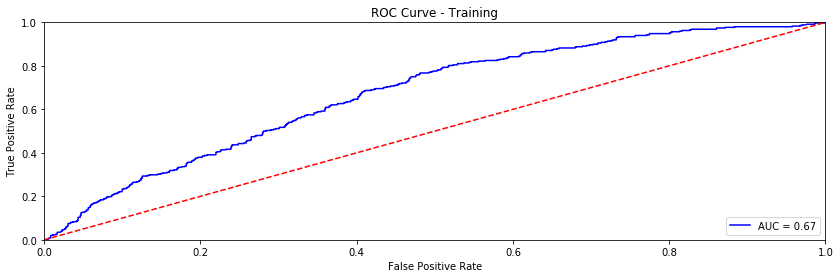

In [178]:
plt.figure(figsize=(14,4))
#plt.title("Feature importance for outer_cv model: ", df2.country_name.unique())
#xgb.plot_importance(model_outer)

#plot ROC curve
fpr, tpr, threshold = metrics.roc_curve(actual_value_second_measure, predicted_probs_first_measure)
roc_auc = metrics.auc(fpr, tpr)


plt.title('ROC Curve - Training')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

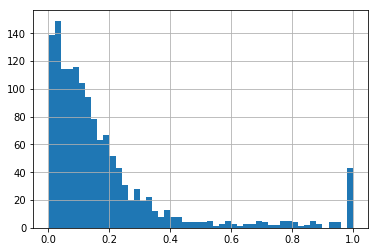

In [173]:
#probabilities are skewed left, 
predicted_probs_first_measure.hist(bins=50)

In [190]:
#create a data frame of the actual values on second measurement and our probabilities from the first predictiojn
plot_results = actual_value_second_measure.join(predicted_probs_first_measure)


(array([ 7.13444659,  4.54682347,  4.32502721,  4.43592534,  3.51177423,
         2.69852125,  2.18099662,  2.03313245,  1.55257387,  1.18291342,
         0.92415111,  0.81325298,  0.51752462,  0.55449067,  0.29572836,
         0.3326944 ,  0.29572836,  0.14786418,  0.11089813,  0.07393209,
         0.11089813,  0.07393209,  0.03696604,  0.11089813,  0.11089813,
         0.03696604,  0.03696604,  0.07393209,  0.03696604,  0.03696604,
         0.07393209,  0.22179627,  0.07393209,  0.07393209,  0.03696604,
         0.07393209,  0.03696604,  0.11089813,  0.        ,  0.9980832 ]),
 array([  8.11411592e-04,   2.57900385e-02,   5.07686654e-02,
          7.57472924e-02,   1.00725919e-01,   1.25704546e-01,
          1.50683173e-01,   1.75661800e-01,   2.00640427e-01,
          2.25619054e-01,   2.50597681e-01,   2.75576308e-01,
          3.00554935e-01,   3.25533562e-01,   3.50512189e-01,
          3.75490815e-01,   4.00469442e-01,   4.25448069e-01,
          4.50426696e-01,   4.75405323e-01

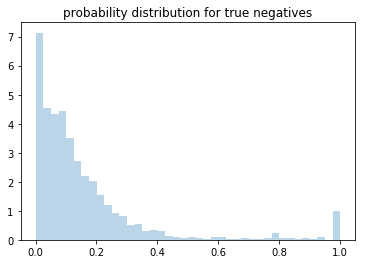

In [195]:
#look at both probabiility distributions for each class

x1 = plot_results[plot_results.status_binary==0].cv_probabilities
x2 = plot_results[plot_results.status_binary==1].cv_probabilities


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives')
plt.hist(x1, **kwargs)

#plt.hist(x3, **kwargs);

(array([ 1.49507942,  2.30012219,  2.53013441,  2.99015884,  4.37023215,
         3.45018328,  3.45018328,  2.87515273,  1.95510386,  1.95510386,
         0.69003666,  1.38007331,  1.15006109,  1.03505498,  0.46002444,
         0.57503055,  0.46002444,  0.11500611,  0.34501833,  0.34501833,
         0.23001222,  0.34501833,  0.23001222,  0.23001222,  0.        ,
         0.23001222,  0.34501833,  0.34501833,  0.34501833,  0.23001222,
         0.23001222,  0.11500611,  0.23001222,  0.        ,  0.34501833,
         0.34501833,  0.11500611,  0.34501833,  0.        ,  1.84009775]),
 array([  3.38685786e-04,   2.53248647e-02,   5.03110435e-02,
          7.52972224e-02,   1.00283401e-01,   1.25269580e-01,
          1.50255759e-01,   1.75241938e-01,   2.00228117e-01,
          2.25214296e-01,   2.50200474e-01,   2.75186653e-01,
          3.00172832e-01,   3.25159011e-01,   3.50145190e-01,
          3.75131369e-01,   4.00117548e-01,   4.25103727e-01,
          4.50089905e-01,   4.75076084e-01

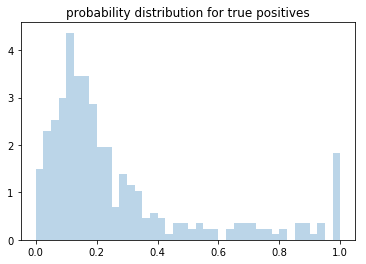

In [197]:
plt.title('probability distribution for true positives')
plt.hist(x2, **kwargs)

prec = tp/ (tp+fp) 

recall = tp/ (tp+fn)

# our mass of "bad wells" exists below 0.5, need to adjust our prediction threshold

In [211]:
test = np.where(predicted_probs_first_measure > .2, 1,0)
print(metrics.confusion_matrix(actual_value_second_measure, test))
print(metrics.recall_score(actual_value_second_measure, test))
print(metrics.recall_score(actual_value_second_measure, predicted_outcome_first_measure))

[[833 250]
 [204 144]]
0.413793103448
0.152298850575


In [225]:
import numpy as np
for i in np.linspace(0,0.5, num=20):
    best = 0
    test = np.where(predicted_probs_first_measure > i, 1,0)
    recall = metrics.recall_score(actual_value_second_measure, test)
    f_score = metrics.f1_score(actual_value_second_measure, test, average='binary')
    print(i,recall, f_score)

0.0 1.0 0.391231028668
0.0263157894737 0.962643678161 0.427295918367
0.0526315789474 0.896551724138 0.439436619718
0.0789473684211 0.830459770115 0.455118110236
0.105263157895 0.755747126437 0.466725820763
0.131578947368 0.632183908046 0.445795339412
0.157894736842 0.540229885057 0.428246013667
0.184210526316 0.456896551724 0.402022756005
0.210526315789 0.390804597701 0.383098591549
0.236842105263 0.333333333333 0.356923076923
0.263157894737 0.304597701149 0.344715447154
0.289473684211 0.293103448276 0.348122866894
0.315789473684 0.247126436782 0.311594202899
0.342105263158 0.215517241379 0.285714285714
0.368421052632 0.201149425287 0.27397260274
0.394736842105 0.186781609195 0.262096774194
0.421052631579 0.17816091954 0.255670103093
0.447368421053 0.169540229885 0.247899159664
0.473684210526 0.16091954023 0.23829787234
0.5 0.152298850575 0.227956989247


## using a threshold of 0.10526 for a bad well.  We will take a hit in false positives but we will catch more bad wells this way

In [229]:
plot_results['f1_max_thresh_pred'] = np.where(plot_results.cv_probabilities>.10526, 1,0)
print(metrics.classification_report(plot_results.status_binary, plot_results.f1_max_thresh_pred))
print(metrics.confusion_matrix(plot_results.status_binary, plot_results.f1_max_thresh_pred))

             precision    recall  f1-score   support

        0.0       0.87      0.52      0.65      1083
        1.0       0.34      0.76      0.47       348

avg / total       0.74      0.58      0.61      1431

[[567 516]
 [ 85 263]]


# Using this approach we accurately find 75% of the bad wells, however have a good bit of false postiives (66%)

In [ ]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [113]:
def append_preds(df, preds, probs):
    #modify to just use a dataframe
    results = df.copy()
    results['cv_predictions']=preds
    results['cv_probabilities']=probs
    
    print("Number of known bad wells (true negatives): ",results.status_binary.sum())
    print("Number of predicted bad wells: ", results.cv_predictions.sum())
    print("Number of predicted bad wells that are recorded as functional (false positives)", results.loc[(results.status_binary==0) & (results.cv_predictions==1)].shape[0])
    print("Number of predicted fucntional wells that are recorded as bad (false negatives)", results.loc[(results.status_binary==1) & (results.cv_predictions==0)].shape[0])
    #print("confusion matrix: \n", metrics.confusion_matrix(Y, preds))
    return results